In [1]:
import xgboost as xgb
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.model_selection  import cross_val_score
import random
from scipy import stats
import seaborn as sns
from copy import deepcopy

%matplotlib inline

%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns',200) 

In [2]:
def read_data():
    data1=pd.read_csv("user_base_info.csv")
    data2=pd.read_csv("user_his_features.csv")
    return data1,data2
data1,data2=read_data()

In [19]:
dataset = pd.merge(data1,data2, how="outer")
dataset

,id,real_age,user_setage,gender,playcard_level,playcard_point,playcard_coupon_num,is_push_open,utm_channel,signup_day,app_version,manufacturer,model,label,add_all_num,add_under_18_num,add_under_30_num,add_under_setage_num,view_all_num,view_under_18_num,view_under_30_num,view_under_setage_num,msg_all_num,msg_under_18_num,msg_under_30_num,msg_under_setage_num,gift_all_num,gift_under_18_num,gift_under_30_num,gift_under_setage_num
0,1,30.0,NaN,1.0,71.0,100.0,10.0,0.0,NaN,163.0,106.0,90.0,592.0,0.0,73.0,3.0,48.0,7.0,3553.0,103.0,1878.0,535.0,102.0,3.0,59.0,12.0,166.0,7.0,99.0,21.0
1,2,36.0,NaN,1.0,19.0,500.0,110.0,1.0,NaN,21.0,29.0,110.0,1180.0,0.0,158.0,11.0,65.0,35.0,1487.0,69.0,648.0,323.0,113.0,7.0,38.0,31.0,88.0,7.0,36.0,21.0
2,3,19.0,0.0,2.0,56.0,0.0,20.0,1.0,7.0,267.0,106.0,90.0,369.0,0.0,18.0,3.0,11.0,3.0,5089.0,260.0,2944.0,777.0,115.0,6.0,73.0,13.0,72.0,4.0,47.0,14.0
3,4,20.0,0.0,2.0,52.0,500.0,0.0,1.0,NaN,651.0,68.0,216.0,1843.0,0.0,20.0,0.0,14.0,2.0,1190.0,39.0,812.0,82.0,54.0,0.0,36.0,3.0,41.0,2.0,27.0,3.0
4,5,51.0,NaN,1.0,28.0,300.0,20.0,0.0,NaN,102.0,73.0,62.0,247.0,0.0,41.0,1.0,28.0,9.0,768.0,26.0,421.0,118.0,65.0,2.0,43.0,12.0,83.0,2.0,55.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37040,37041,19.0,NaN,2.0,60.0,400.0,30.0,1.0,NaN,186.0,68.0,100.0,2016.0,0.0,45.0,1.0,33.0,2.0,3841.0,71.0,2500.0,261.0,101.0,1.0,69.0,13.0,109.0,0.0,79.0,9.0
37041,37042,19.0,0.0,2.0,21.0,800.0,0.0,1.0,NaN,256.0,30.0,100.0,1126.0,0.0,131.0,6.0,72.0,17.0,1737.0,56.0,850.0,295.0,137.0,8.0,63.0,22.0,97.0,7.0,47.0,23.0
37042,37043,41.0,0.0,2.0,42.0,900.0,40.0,1.0,NaN,100.0,29.0,62.0,1007.0,0.0,9.0,1.0,3.0,0.0,846.0,20.0,459.0,86.0,33.0,0.0,16.0,1.0,57.0,0.0,27.0,4.0
37043,37044,29.0,0.0,1.0,65.0,500.0,0.0,1.0,NaN,542.0,68.0,100.0,927.0,1.0,13.0,0.0,7.0,1.0,2008.0,62.0,1138.0,218.0,66.0,3.0,43.0,11.0,143.0,1.0,81.0,10.0


In [38]:
dataset.describe()

,id,real_age,user_setage,gender,playcard_level,playcard_point,playcard_coupon_num,is_push_open,utm_channel,signup_day,app_version,manufacturer,model,label,add_all_num,add_under_18_num,add_under_30_num,add_under_setage_num,view_all_num,view_under_18_num,view_under_30_num,view_under_setage_num,msg_all_num,msg_under_18_num,msg_under_30_num,msg_under_setage_num,gift_all_num,gift_under_18_num,gift_under_30_num,gift_under_setage_num
count,37045.000000,35421.000000,24455.000000,37003.000000,35396.000000,35396.000000,35396.000000,37000.000000,15817.000000,37003.000000,37037.000000,37037.000000,37037.000000,36224.000000,36863.000000,36863.000000,36863.000000,36863.000000,37043.000000,37043.000000,37043.000000,37043.000000,37024.000000,37024.000000,37024.000000,37024.000000,37026.000000,37026.000000,37026.000000,37026.000000
mean,18523.000000,30.380368,0.123942,1.517526,50.998446,439.820884,53.883207,0.777135,25.567870,499.012323,66.438534,115.199800,1118.087777,0.083011,91.855546,2.954344,52.068036,11.302064,2682.457468,86.790514,1476.375968,360.146289,145.101691,5.264072,76.152037,21.658924,126.836223,3.989089,70.860990,17.073651
std,10694.114698,11.205037,0.329522,0.507694,24.919628,287.339013,189.117664,0.416174,17.663456,368.111279,27.990100,56.708461,678.085024,0.275903,100.990244,4.594477,58.631622,18.956114,2619.965055,103.555709,1449.569272,484.161601,162.510694,8.852593,85.118821,43.952522,138.253570,5.671516,84.282981,26.311556
min,1.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,9262.000000,23.000000,0.000000,1.000000,31.000000,200.000000,0.000000,1.000000,7.000000,239.000000,58.000000,90.000000,592.000000,0.000000,26.000000,0.000000,15.000000,1.000000,904.000000,22.000000,486.000000,84.000000,51.000000,1.000000,26.000000,3.000000,46.000000,1.000000,23.000000,3.000000
50%,18523.000000,27.000000,0.000000,2.000000,57.000000,400.000000,10.000000,1.000000,33.000000,486.000000,68.000000,90.000000,1032.000000,0.000000,62.000000,1.000000,35.000000,5.000000,1930.000000,53.000000,1052.000000,205.000000,102.000000,3.000000,53.000000,10.000000,90.000000,2.000000,47.000000,9.000000
75%,27784.000000,34.000000,0.000000,2.000000,70.000000,700.000000,30.000000,1.000000,43.000000,636.000000,73.000000,110.000000,1705.000000,0.000000,120.500000,4.000000,68.000000,13.000000,3599.500000,112.000000,1990.000000,443.000000,186.000000,7.000000,98.000000,24.000000,160.000000,5.000000,88.000000,21.000000
max,37045.000000,94.000000,1.000000,2.000000,923.000000,900.000000,10650.000000,1.000000,50.000000,2679.000000,107.000000,239.000000,2285.000000,1.000000,1761.000000,133.000000,1220.000000,473.000000,54916.000000,2834.000000,20893.000000,15151.000000,5164.000000,346.000000,3198.000000,2482.000000,3364.000000,150.000000,1541.000000,934.000000


array([[<AxesSubplot:title={'center':'real_age'}>,
        <AxesSubplot:title={'center':'user_setage'}>,
        <AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'playcard_level'}>,
        <AxesSubplot:title={'center':'playcard_point'}>],
       [<AxesSubplot:title={'center':'playcard_coupon_num'}>,
        <AxesSubplot:title={'center':'is_push_open'}>,
        <AxesSubplot:title={'center':'utm_channel'}>,
        <AxesSubplot:title={'center':'signup_day'}>,
        <AxesSubplot:title={'center':'app_version'}>],
       [<AxesSubplot:title={'center':'manufacturer'}>,
        <AxesSubplot:title={'center':'model'}>,
        <AxesSubplot:title={'center':'label'}>,
        <AxesSubplot:title={'center':'add_all_num'}>,
        <AxesSubplot:title={'center':'add_under_18_num'}>],
       [<AxesSubplot:title={'center':'add_under_30_num'}>,
        <AxesSubplot:title={'center':'add_under_setage_num'}>,
        <AxesSubplot:title={'center':'view_all_num'}>,
        <A

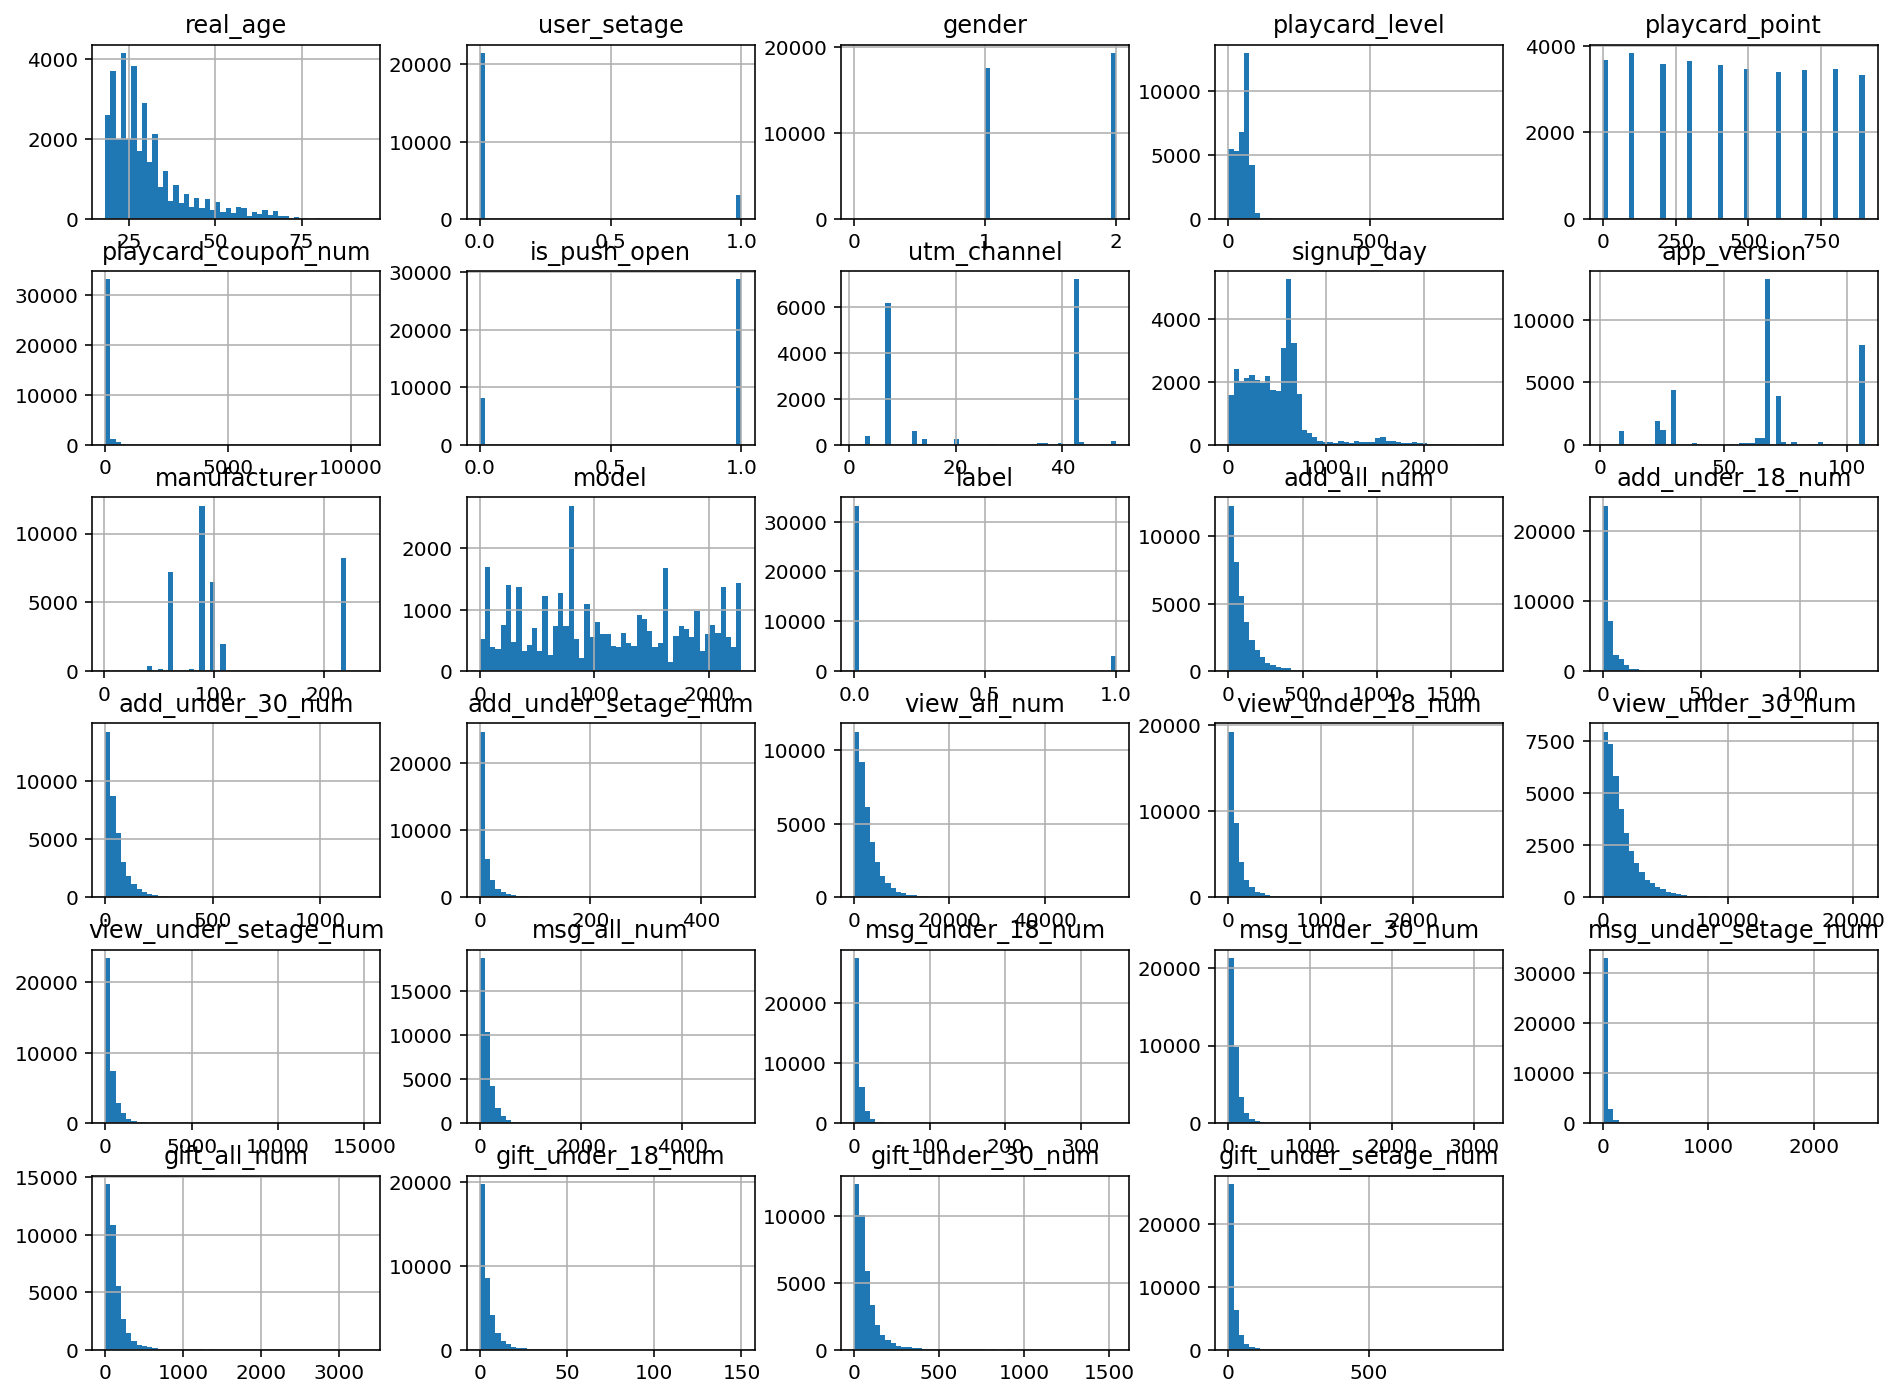

In [76]:
cont_features = [cont for cont in list(dataset.select_dtypes(include=['float64','int64']))if cont not in ['id'] ]
dataset[cont_features].hist(bins=50,figsize=(16,12))

In [39]:
dataset1=dataset.dropna(subset=['label'])
dataset1=dataset1.drop('id',axis=1)
train_x=dataset1.drop('label',axis=1)
train_y=dataset1['label']


In [40]:
train_x

,real_age,user_setage,gender,playcard_level,playcard_point,playcard_coupon_num,is_push_open,utm_channel,signup_day,app_version,manufacturer,model,add_all_num,add_under_18_num,add_under_30_num,add_under_setage_num,view_all_num,view_under_18_num,view_under_30_num,view_under_setage_num,msg_all_num,msg_under_18_num,msg_under_30_num,msg_under_setage_num,gift_all_num,gift_under_18_num,gift_under_30_num,gift_under_setage_num
0,30.0,NaN,1.0,71.0,100.0,10.0,0.0,NaN,163.0,106.0,90.0,592.0,73.0,3.0,48.0,7.0,3553.0,103.0,1878.0,535.0,102.0,3.0,59.0,12.0,166.0,7.0,99.0,21.0
1,36.0,NaN,1.0,19.0,500.0,110.0,1.0,NaN,21.0,29.0,110.0,1180.0,158.0,11.0,65.0,35.0,1487.0,69.0,648.0,323.0,113.0,7.0,38.0,31.0,88.0,7.0,36.0,21.0
2,19.0,0.0,2.0,56.0,0.0,20.0,1.0,7.0,267.0,106.0,90.0,369.0,18.0,3.0,11.0,3.0,5089.0,260.0,2944.0,777.0,115.0,6.0,73.0,13.0,72.0,4.0,47.0,14.0
3,20.0,0.0,2.0,52.0,500.0,0.0,1.0,NaN,651.0,68.0,216.0,1843.0,20.0,0.0,14.0,2.0,1190.0,39.0,812.0,82.0,54.0,0.0,36.0,3.0,41.0,2.0,27.0,3.0
4,51.0,NaN,1.0,28.0,300.0,20.0,0.0,NaN,102.0,73.0,62.0,247.0,41.0,1.0,28.0,9.0,768.0,26.0,421.0,118.0,65.0,2.0,43.0,12.0,83.0,2.0,55.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37040,19.0,NaN,2.0,60.0,400.0,30.0,1.0,NaN,186.0,68.0,100.0,2016.0,45.0,1.0,33.0,2.0,3841.0,71.0,2500.0,261.0,101.0,1.0,69.0,13.0,109.0,0.0,79.0,9.0
37041,19.0,0.0,2.0,21.0,800.0,0.0,1.0,NaN,256.0,30.0,100.0,1126.0,131.0,6.0,72.0,17.0,1737.0,56.0,850.0,295.0,137.0,8.0,63.0,22.0,97.0,7.0,47.0,23.0
37042,41.0,0.0,2.0,42.0,900.0,40.0,1.0,NaN,100.0,29.0,62.0,1007.0,9.0,1.0,3.0,0.0,846.0,20.0,459.0,86.0,33.0,0.0,16.0,1.0,57.0,0.0,27.0,4.0
37043,29.0,0.0,1.0,65.0,500.0,0.0,1.0,NaN,542.0,68.0,100.0,927.0,13.0,0.0,7.0,1.0,2008.0,62.0,1138.0,218.0,66.0,3.0,43.0,11.0,143.0,1.0,81.0,10.0


In [41]:
train_y

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
37040    0.0
37041    0.0
37042    0.0
37043    1.0
37044    0.0
Name: label, Length: 36224, dtype: float64

In [113]:
import pandas as pd 
import numpy as np
import xgboost as xgb
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder,LabelBinarizer,Binarizer
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score
from icecream import ic
from xgboost import XGBRegressor
from xgboost.sklearn import XGBClassifier
import warnings
from sklearn import metrics
warnings.filterwarnings('ignore')
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [114]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=2)
X_train.tail(5)
len(X_train)

28979

In [115]:
len(y_train)

28979

In [139]:
clf = XGBClassifier(
silent=0 ,#设置成1则没有运行信息输出，最好是设置为0.是否在运行升级时打印消息。
#nthread=4,# cpu 线程数 默认最大
learning_rate= 0.1, # 如同学习率
min_child_weight=1, 
# 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
#，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
#这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
max_depth=6,#深度，越大越容易过拟合
gamma=0.1,  # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
subsample=0.8, # 随机采样训练样本 训练实例的子采样比
colsample_btree=0.8,  
max_delta_step=0,#最大增量步长，我们允许每个树的权重估计。
colsample_bytree=1, # 生成树时进行的列采样 
reg_lambda=1,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
#reg_alpha=0, # L1 正则项参数
#scale_pos_weight=1, #如果取值大于0的话，在类别样本不平衡的情况下有助于快速收敛。平衡正负权重
#objective= 'multi:softmax', #多分类的问题 指定学习任务和相应的学习目标
#num_class=10, # 类别数，多分类与 multisoftmax 并用
n_estimators=150, #树的个数
seed=1000, #随机种子
#eval_metric= 'auc'
scale_pos_weight =0.1
)
clf.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],eval_metric='error',early_stopping_rounds=20,verbose=True)
y_pred=clf.predict(X_test)

[16:00:38] WARNING: ..\src\learner.cc:541: 
Parameters: { colsample_btree, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.07940	validation_1-error:0.07812
[1]	validation_0-error:0.08106	validation_1-error:0.08019
[2]	validation_0-error:0.08095	validation_1-error:0.08033
[3]	validation_0-error:0.08113	validation_1-error:0.08033
[4]	validation_0-error:0.08127	validation_1-error:0.08006
[5]	validation_0-error:0.08130	validation_1-error:0.07992
[6]	validation_0-error:0.08120	validation_1-error:0.08033
[7]	validation_0-error:0.08116	validation_1-error:0.08047
[8]	validation_0-error:0.08127	validation_1-error:0.08033
[9]	validation_0-error:0.08120	validation_1-error:0.07992
[10]	validation_0-error:0.08106	validation_1-error:0.07992
[11]	validation_0-

In [140]:
auc=accuracy_score(y_test,y_pred)
roc=roc_auc_score(y_test,y_pred)
prc=precision_score(y_test,y_pred)
rec=recall_score(y_test, y_pred, average='macro')
finalscore=5*prc*rec/(2*prc+3*rec)
ic(auc)
ic(roc)
ic(prc)
ic(rec)
ic(finalscore)

ic| auc: 0.9218771566597653
ic| roc: 0.5266353202753744
ic| prc: 0.8888888888888888
ic| rec: 0.5266353202753744
ic| finalscore: 0.6970881136111148


0.6970881136111148

In [110]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred, pos_label=1)

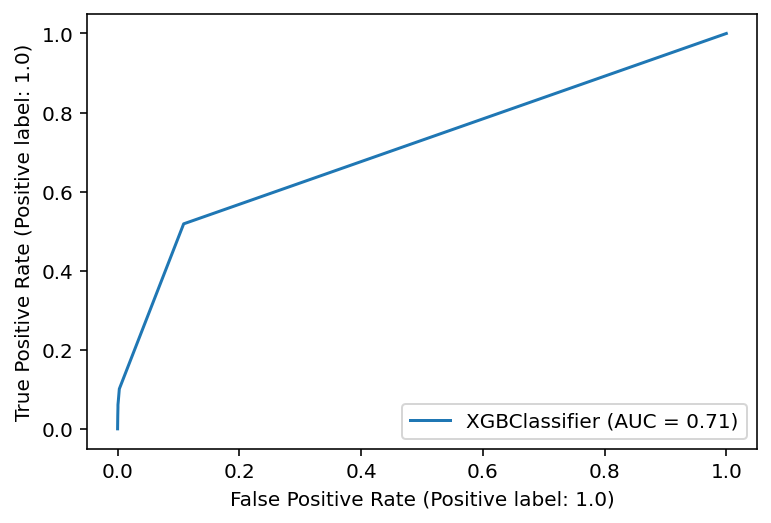

In [111]:

lr_roc = metrics.plot_roc_curve(estimator=clf, X=X_test, 
                        y=y_test)

In [91]:
test=pd.read_csv('test_a.csv')

In [92]:
lists=[]
for j in range(365):
    index=test.loc[j,'id']
    lists.append(index)
inputw=dataset.drop('label',axis=1)
inputw=inputw.iloc[lists,:]
inputw=inputw.drop('id',axis=1)


In [93]:
inputw

,real_age,user_setage,gender,playcard_level,playcard_point,playcard_coupon_num,is_push_open,utm_channel,signup_day,app_version,manufacturer,model,add_all_num,add_under_18_num,add_under_30_num,add_under_setage_num,view_all_num,view_under_18_num,view_under_30_num,view_under_setage_num,msg_all_num,msg_under_18_num,msg_under_30_num,msg_under_setage_num,gift_all_num,gift_under_18_num,gift_under_30_num,gift_under_setage_num
313,30.0,0.0,2.0,65.0,800.0,0.0,1.0,7.0,601.0,68.0,216.0,436.0,33.0,4.0,24.0,5.0,1365.0,108.0,797.0,195.0,244.0,31.0,144.0,48.0,183.0,12.0,73.0,57.0
520,24.0,NaN,2.0,23.0,200.0,0.0,1.0,NaN,372.0,73.0,62.0,1793.0,15.0,0.0,9.0,2.0,311.0,3.0,169.0,31.0,16.0,0.0,8.0,3.0,26.0,1.0,16.0,1.0
606,23.0,0.0,1.0,32.0,300.0,1040.0,0.0,NaN,522.0,106.0,90.0,2279.0,30.0,0.0,17.0,4.0,1704.0,83.0,1074.0,168.0,142.0,10.0,91.0,12.0,36.0,2.0,23.0,5.0
834,21.0,0.0,1.0,68.0,700.0,20.0,1.0,NaN,1052.0,106.0,90.0,782.0,82.0,0.0,51.0,4.0,6082.0,232.0,3745.0,616.0,268.0,6.0,183.0,12.0,117.0,0.0,82.0,5.0
1062,30.0,0.0,1.0,76.0,700.0,0.0,1.0,NaN,600.0,68.0,62.0,2272.0,85.0,4.0,42.0,12.0,3755.0,70.0,2221.0,343.0,118.0,3.0,75.0,11.0,107.0,0.0,66.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34075,36.0,1.0,1.0,67.0,800.0,0.0,1.0,NaN,484.0,68.0,62.0,775.0,277.0,13.0,79.0,94.0,4635.0,270.0,1369.0,1561.0,422.0,22.0,78.0,157.0,75.0,5.0,12.0,37.0
35049,63.0,1.0,2.0,14.0,100.0,0.0,1.0,12.0,558.0,29.0,110.0,80.0,152.0,7.0,54.0,41.0,3491.0,120.0,1321.0,855.0,196.0,7.0,61.0,53.0,60.0,0.0,15.0,23.0
35159,21.0,0.0,2.0,31.0,300.0,10.0,1.0,NaN,289.0,106.0,90.0,1610.0,11.0,0.0,10.0,1.0,137.0,0.0,81.0,5.0,6.0,0.0,3.0,0.0,7.0,0.0,6.0,0.0
35320,38.0,0.0,2.0,16.0,700.0,50.0,0.0,48.0,475.0,29.0,100.0,845.0,139.0,1.0,84.0,4.0,1412.0,39.0,833.0,126.0,144.0,2.0,76.0,10.0,147.0,3.0,96.0,10.0


In [94]:
pre=clf.predict(inputw)
pre.astype(int)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [95]:
np.savetxt('submit_sample_b.txt',pre,delimiter="\n",fmt="%.d")